c:\Users\user\anaconda3\envs\load_forecasting\lib\site-packages\statsforecast\core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
import funcs.data_wrangling as dw
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import rcParams
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsforecast.models import MSTL, AutoARIMA

rcParams['figure.figsize'] = 15, 5

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = dw.ons_data(freq='h', ano_inicio=2000, ano_fim=2023, idreg="S")
df = dw.pipeline(data, update=False)

Descritivo

In [4]:
df.head()

,id_reg,desc_reg,load_mwmed
date,,,
2000-01-01 00:00:00,S,SUL,5777.0
2000-01-01 01:00:00,S,SUL,5580.7
2000-01-01 02:00:00,S,SUL,5098.7
2000-01-01 03:00:00,S,SUL,4753.7
2000-01-01 04:00:00,S,SUL,4584.1


In [5]:
df.tail()

,id_reg,desc_reg,load_mwmed
date,,,
2023-02-28 19:00:00,S,SUL,15729.787
2023-02-28 20:00:00,S,SUL,15462.559
2023-02-28 21:00:00,S,SUL,15239.738
2023-02-28 22:00:00,S,SUL,14644.277
2023-02-28 23:00:00,S,SUL,13548.623


In [6]:
df.sample(5)

,id_reg,desc_reg,load_mwmed
date,,,
2022-05-12 13:00:00,S,SUL,11058.522979
2022-08-16 19:00:00,S,SUL,13952.376000
2019-07-12 15:00:00,S,SUL,12328.411000
2016-03-16 07:00:00,S,SUL,11408.814692
2016-06-24 01:00:00,S,SUL,8461.963000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 203040 entries, 2000-01-01 00:00:00 to 2023-02-28 23:00:00
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id_reg      203040 non-null  object 
 1   desc_reg    203040 non-null  object 
 2   load_mwmed  203040 non-null  float64
dtypes: float64(1), object(2)
memory usage: 6.2+ MB


In [8]:
df.reset_index().describe(include='all')

,date,id_reg,desc_reg,load_mwmed
count,203040,203040,203040,203040.000000
unique,203040,1,1,NaN
top,2000-01-01 00:00:00,S,SUL,NaN
freq,1,203040,203040,NaN
first,2000-01-01 00:00:00,NaN,NaN,NaN
last,2023-02-28 23:00:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,9298.189359
std,NaN,NaN,NaN,2559.348673
min,NaN,NaN,NaN,3615.830005
25%,NaN,NaN,NaN,7410.587250


In [9]:
df.isna().sum()

id_reg        0
desc_reg      0
load_mwmed    0
dtype: int64

In [10]:
zeros = (df["load_mwmed"] == 0).sum()
print(f"Zeros: {zeros} ({zeros/df.shape[0]:%})")

Zeros: 0 (0.000000%)


Visualização

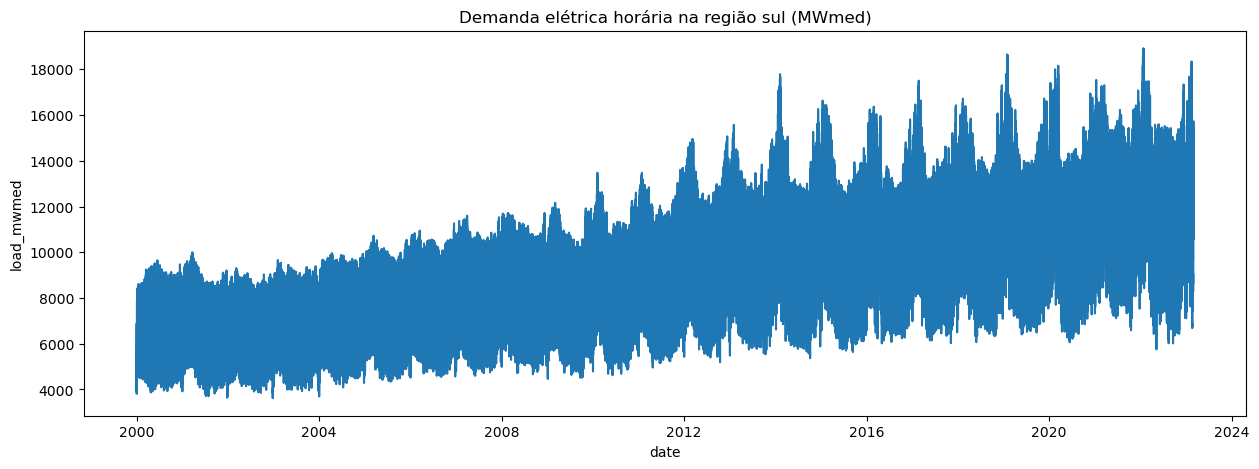

In [11]:
plt.figure()

sns.lineplot(x = "date", y = "load_mwmed", data = df)

plt.title("Demanda elétrica horária na região sul (MWmed)")

plt.show()

In [12]:
data.get_seasonal_components()
df_seasonal = data.seasonal_components
df_seasonal["load_mwmed"] = df["load_mwmed"].values
df_seasonal.head()
df_seasonal

,data,ano,trimestre,mes,semana_ano,dia,dia_ano,dia_semana,hora,apagao,load_mwmed
0,2000-01-01 00:00:00,2000,1,1,52,1,1,6,0,0,5777.000
1,2000-01-01 01:00:00,2000,1,1,52,1,1,6,1,0,5580.700
2,2000-01-01 02:00:00,2000,1,1,52,1,1,6,2,0,5098.700
3,2000-01-01 03:00:00,2000,1,1,52,1,1,6,3,0,4753.700
4,2000-01-01 04:00:00,2000,1,1,52,1,1,6,4,0,4584.100
...,...,...,...,...,...,...,...,...,...,...,...
203035,2023-02-28 19:00:00,2023,1,2,9,28,59,2,19,0,15729.787
203036,2023-02-28 20:00:00,2023,1,2,9,28,59,2,20,0,15462.559
203037,2023-02-28 21:00:00,2023,1,2,9,28,59,2,21,0,15239.738
203038,2023-02-28 22:00:00,2023,1,2,9,28,59,2,22,0,14644.277


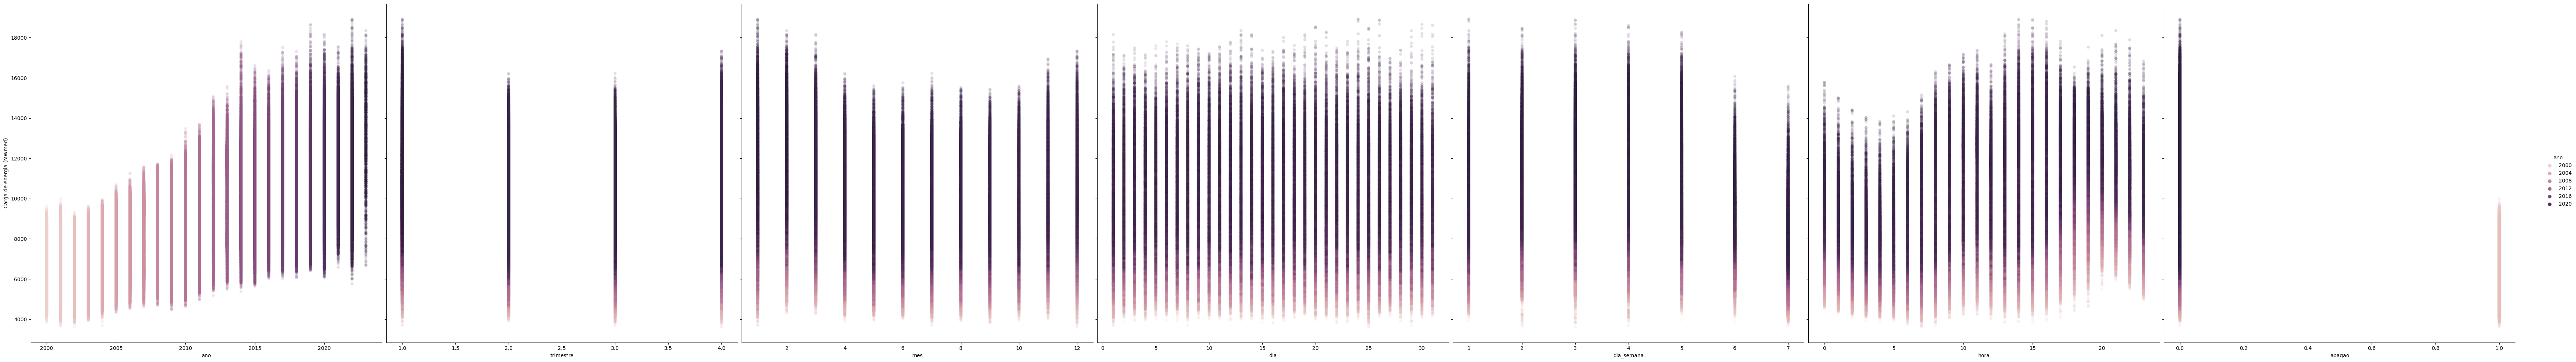

In [13]:
g = sns.pairplot(df_seasonal, 
             hue = "ano", 
             x_vars = [ "ano", "trimestre", "mes", "dia", "dia_semana", "hora", "apagao"],
             y_vars = "load_mwmed",
             height = 10,
             plot_kws={'alpha':0.15, 'linewidth':0, 'palette': 'coolwarm'})

g.axes.flat[0].set_ylabel("Carga de energia (MWmed)")

plt.show()

In [14]:
df_seasonal_dif = df_seasonal.copy(deep=True)
df_seasonal_dif.loc[:,"load_mwmed"] = df_seasonal_dif.loc[:,"load_mwmed"].diff()

g = sns.pairplot(df_seasonal_dif, 
             hue = "ano", 
             x_vars = [ "ano", "trimestre", "mes", "dia", "dia_semana", "hora", "apagao"],
             y_vars = "load_mwmed",
             height = 10,
             plot_kws={'alpha':0.15, 'linewidth':0, 'palette': 'coolwarm'})

g.axes.flat[0].set_ylabel("Carga de energia (MWmed)")

plt.show()

Text(0.5, 1.0, 'ACF - nível')

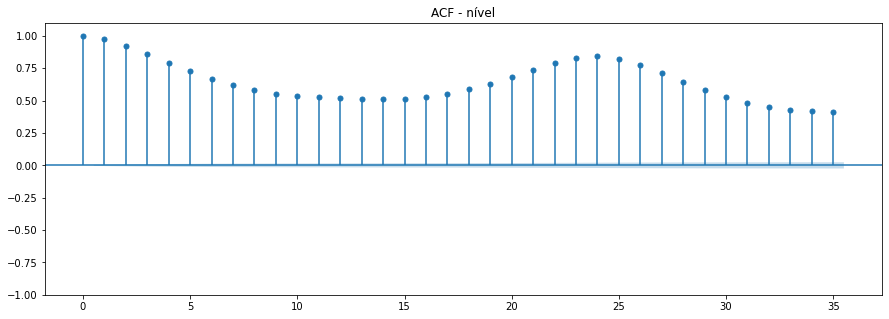

In [ ]:
plot_acf(df["load_mwmed"], lags=35)
plt.ylim(-1,1.1)
plt.title("ACF - nível")

Text(0.5, 1.0, 'PACF - nível')

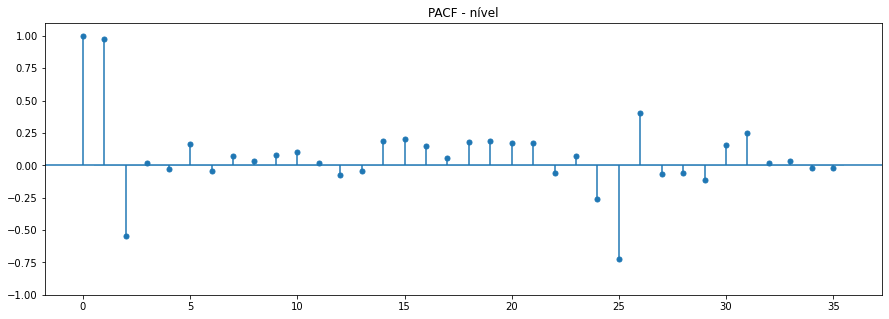

In [ ]:
plot_pacf(df["load_mwmed"], lags=35)
plt.ylim(-1,1.1)
plt.title("PACF - nível")

Text(0.5, 1.0, 'ACF - d(1)')

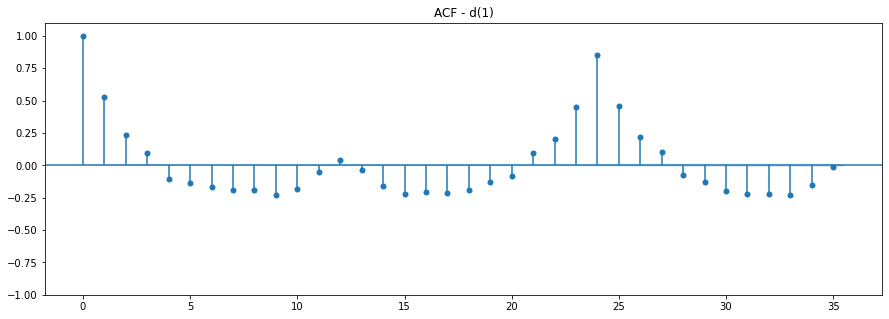

In [ ]:
plot_acf(df["load_mwmed"].diff().dropna(), lags=35)
plt.ylim(-1,1.1)
plt.title("ACF - d(1)")
#plt.show()

Text(0.5, 1.0, 'ACF - d(1)')

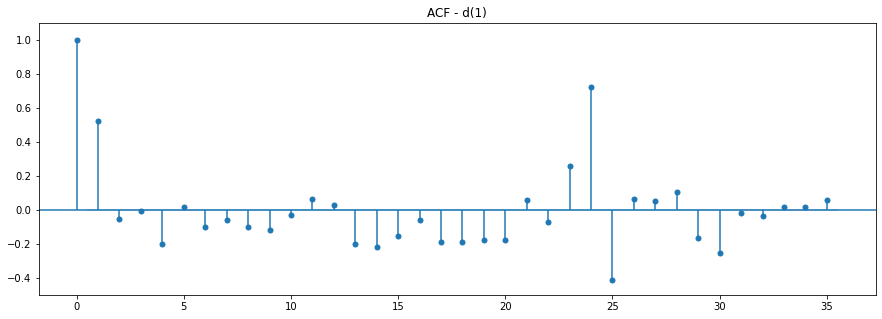

In [ ]:
plot_pacf(df["load_mwmed"].diff().dropna(), lags=35)
plt.ylim(-0.5,1.1)
plt.title("ACF - d(1)")

Text(0.5, 1.0, 'ACF - d(24) d(1)')

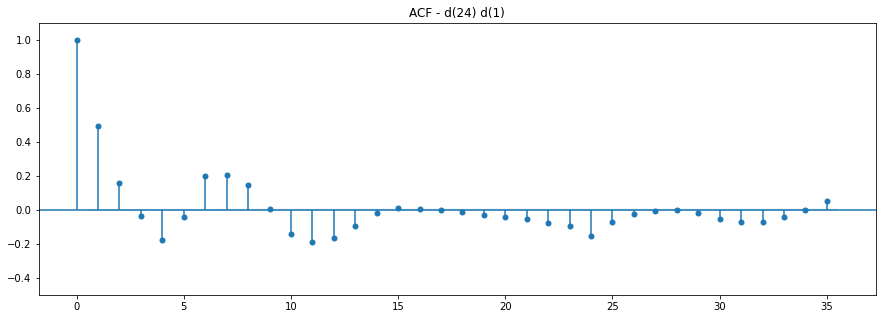

In [ ]:
plot_acf(df["load_mwmed"].diff(24).diff().dropna(), lags=35)
plt.ylim(-0.5,1.1)
plt.title("ACF - d(24) d(1)")

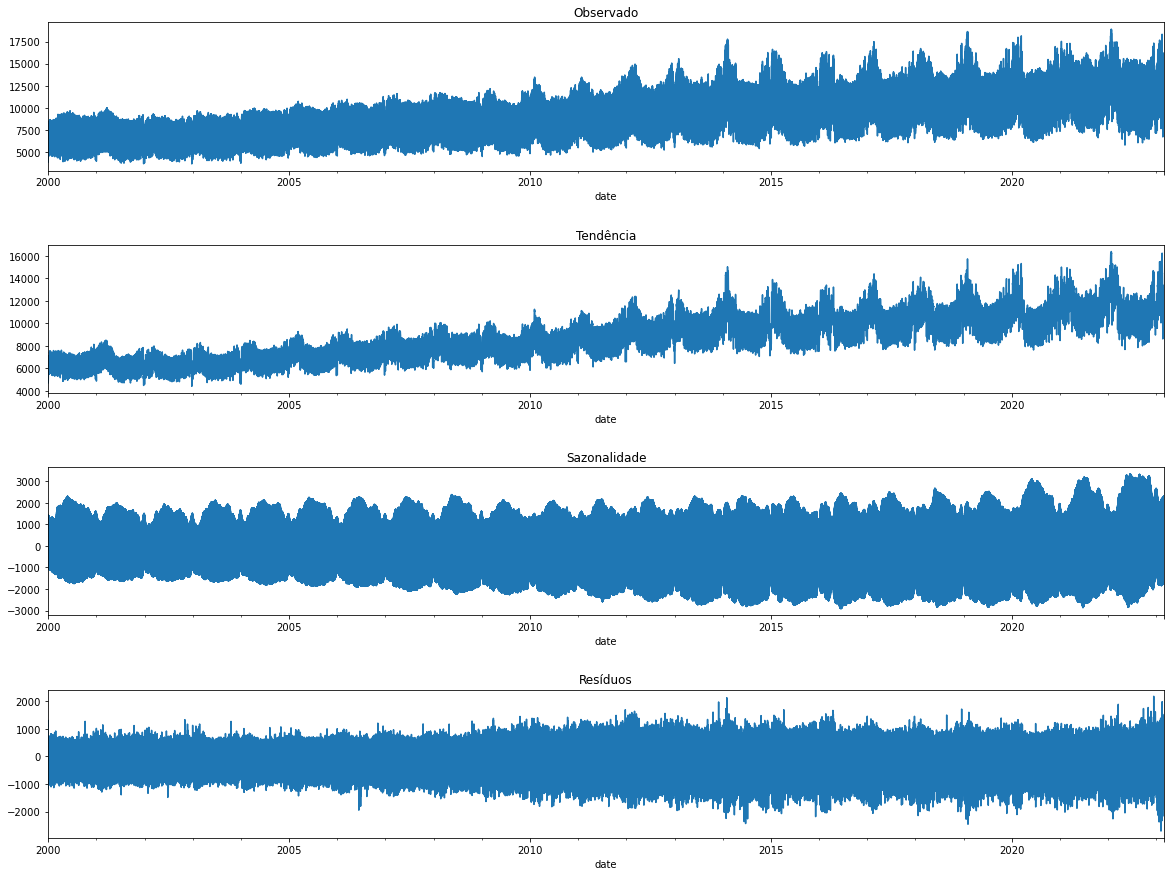

In [ ]:
df2 = pd.Series(df["load_mwmed"], index=df.index)
df2 = df2.asfreq('h')


fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, figsize = (20,15))
decompose_data = STL(df2, period=24, seasonal=25)
decompose_data = decompose_data.fit()

decompose_data.observed.plot(ax = ax1, title = "Observado")
decompose_data.trend.plot(ax = ax2, title = "Tendência")
decompose_data.seasonal.plot(ax = ax3, title = "Sazonalidade")
decompose_data.resid.plot(ax = ax4, title = "Resíduos")

plt.subplots_adjust(hspace= 0.5)
plt.show()